### Imports

In [230]:
import seaborn as sns
import numpy as np
import tensorflow as tf
import pandas as pd
import warnings

# import matplotlib
# import matplotlib.font_manager as fm

from glob import glob
from pathlib import Path
from os import stat, path, makedirs
from collections import defaultdict
from matplotlib import pyplot as plt
from Bio import AlignIO
from scipy import stats
from matplotlib import rcParams, font_manager, patches, rcParamsDefault

from collections import Counter
from tqdm import tqdm
from matplotlib.colors import TwoSlopeNorm


### Global variables

In [99]:
%matplotlib inline

plt.rcParams["font.family"] = "Arial"

# sns.set(style="whitegrid",
#         font_scale=1.5)

pred_dic = {
    "TN": "True negatives",
    "FP": "False positives",
    "FN": "False negatives",
    "TP": "True positives"
}

tp_fn_pal = {
    "FN": "#463A85",
    "TP": "#4EA4DC", 
    "TN": "#A81E23",
    "FP": "#DA6E54"
}

## output directories
Path("figures/baseline").mkdir(parents=True, exist_ok=True)

### Function definitions

In [235]:
def parse_site_omegas(control_file):
    with open(control_file, "r") as f:
        lines = [line.strip() for line in f.readlines()]
    submodel_i = lines.index("[submodel]")
    classes = [float(i) for i in lines[submodel_i + 3].split(" ")]
    class_dic = {}
    for i in [0, 1, 2]:
        class_dic[i] = classes[i]
    return class_dic


def determine_true_omegas(clustal_align, true_align, true_classes):
    all_omegas = []
    for i_seq, true_seq in enumerate(true_align):
        alt_run = 0
        clustal_codons = clustal_align[i_seq]
        omegas = []
        for i_cod, codon in enumerate(true_seq):
            if codon == "---":
                continue
            while clustal_codons[alt_run] == "---":
                alt_run += 1
                omegas.append(np.nan)
            else:
                assert codon == clustal_codons[alt_run]
                omegas.append(true_classes[i_cod])
                alt_run += 1
        if len(omegas) != len(clustal_align[i_seq]):
            to_gap = len(clustal_align[i_seq]) - len(omegas)
            for i in range(to_gap):
                omegas.append(np.nan)
        all_omegas.append(omegas)
    return np.asarray(all_omegas)


def determine_true_sites(clustal_align, true_align, true_classes):
    all_site_classes = []
    for i_seq, true_seq in enumerate(true_align):
        alt_run = 0
        clustal_codons = clustal_align[i_seq]
        site_classes = []
        for i_cod, codon in enumerate(true_seq):
            if codon == "---":
                continue
            while clustal_codons[alt_run] == "---":
                alt_run += 1
                site_classes.append(3)
            else:
                assert codon == clustal_codons[alt_run]
                site_classes.append(true_classes[i_cod])
                alt_run += 1
        if len(site_classes) != len(clustal_align[i_seq]):
            to_gap = len(clustal_align[i_seq]) - len(site_classes)
            for i in range(to_gap):
                site_classes.append(3)
        site_classes = sum(zip(site_classes,site_classes,site_classes), ())
        all_site_classes.append(site_classes)
    return np.asarray(all_site_classes)


def determine_true_alignment_sites(clustal_align, true_align, true_classes):
    all_site_classes = []
    for i_seq, true_seq in enumerate(true_align):
        clustal_codons = clustal_align[i_seq]
        site_classes = []
        for i_cod, codon in enumerate(true_seq):
            if codon == "---":
                site_classes.append(3)
                continue
            else:
                site_classes.append(true_classes[i_cod])
        site_classes = sum(zip(site_classes,site_classes,site_classes), ())
        all_site_classes.append(site_classes)
    return np.asarray(all_site_classes)


def parse_site_classes(fi, class_dic):
    with open(fi, "r") as f:
        site_lines = [line.strip() for line in f.readlines()]
    site_lines = site_lines[site_lines.index("Site\tClass\tPartition\tInserted?")+1:]
    site_omegas = [class_dic[int(i.split("\t")[1])] for i in site_lines]
    site_classes = [int(i.split("\t")[1]) for i in site_lines]
    return site_omegas, site_classes


def parse_align_sequence(fi):
    fas = AlignIO.read(fi, "fasta")
    seq_list = []
    for record in fas:
        seq = str(record.seq)
        chunks, chunk_size = len(seq), 3
        seq = [seq[i:i+chunk_size] for i in range(0, chunks, chunk_size)]
        seq_list.append(seq)
    return seq_list


def parse_alignment(file_name):
    # discard alignment if entirely deleted
    if stat(file_name).st_size == 0:
        print("returning all delete")
        return None
    encoding = {"-": [1, 0, 0, 0, 0],
                "A": [0, 1, 0, 0, 0],
                "C": [0, 0, 1, 0, 0],
                "G": [0, 0, 0, 1, 0],
                "T": [0, 0, 0, 0, 1]}
    x_seqs = []
    lines_read = 0
    with open(str(file_name), "r") as file:
        sequence = []
        for line in file:
            if line[0] == ">" and lines_read != 0:
                # discard alignment if entirely deleted
                if len(sequence) < 100:
                    print("returning none")
                    return None
                x_seqs.append(np.asarray(sequence, dtype=np.float32))
                sequence = []
            elif line[0].isalpha() or line[0] == "-":
                for char in line.rstrip("\n"):
                    sequence.append(encoding[char])
            lines_read += 1
        x_seqs.append(np.asarray(sequence, dtype=np.float32))
    x_seqs = tf.convert_to_tensor(x_seqs)
    return x_seqs


def get_label(label_file):
    with open(label_file, "r") as y_fi:
        if y_fi.read(1) == "1":
            return 1
        else:
            return 0


def saliency(model, x):
    # calculate saliency
    y_pred = model.predict(x)

    alignment_tensor = tf.Variable(x, dtype=float)
    with tf.GradientTape() as tape:
        pred = model(alignment_tensor, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
        loss = pred[0][class_idxs_sorted[0]]

    grads = tape.gradient(loss, alignment_tensor)
    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
    arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
    return grad_eval


def codon_class_saliency(true_clustal_classes, sorted_site_omegas, grad_eval, y_lab, y_pred, saliency_bins):
    pred_y = round(y_pred[0][0])
    saliency_dic = defaultdict(float)
    n_of_sites = defaultdict(int)
    
    bins = np.arange(0,1.1,0.1)
    centers = (bins[1:]+bins[:-1])/2
    total_saliency = 0
    
    for species in range(len(true_clustal_classes)):
        for i_codon, codon in enumerate(true_clustal_classes[species]):
            total_saliency += grad_eval[species][i_codon]
            # nan = gap
            if np.isnan(codon):
                codon = "3.0"
                saliency_dic[codon] += grad_eval[species][i_codon] # 3.0 = gaps
                n_of_sites[codon] += 1
            else:
                saliency_dic[str(codon)] += grad_eval[species][i_codon]
                n_of_sites[str(codon)] += 1
            # place saliency into bin
            sal_bin = bins[np.digitize(grad_eval[species][i_codon], centers)]
            if y_lab == pred_y:
                if y_lab == 1:
                    saliency_bins["TP"][sal_bin].append(int(codon))
                else:
                    saliency_bins["TN"][sal_bin].append(int(codon))
            elif y_lab != pred_y:
                if y_lab == 1:
                    saliency_bins["FN"][sal_bin].append(int(codon))
                else:
                    saliency_bins["FP"][sal_bin].append(int(codon))
                
    saliency_median_dic = {}
    for k, v in saliency_dic.items():
        saliency_median_dic[str(k) + "median"] = np.median(saliency_dic[k])
    for k, v in saliency_dic.items():
        saliency_dic[k] /= n_of_sites[k]
    for k, v in saliency_median_dic.items():
        saliency_dic[k] = v
    saliency_dic["true_y"] = y_lab
    saliency_dic["pred_y"] = pred_y
    if y_lab == pred_y:
        if y_lab == 1:
            saliency_dic["prediction"] = "TP"
        else:
            saliency_dic["prediction"] = "TN"
    elif y_lab != pred_y:
        if y_lab == 1:
            saliency_dic["prediction"] = "FN"
        else:
            saliency_dic["prediction"] = "FP"
    for i in [0,1,2]:
        try:
            saliency_dic["omega_{}".format(i)] = sorted_site_omegas[i]
        except IndexError:
            saliency_dic["omega_{}".format(i)] = np.nan
    saliency_dic["total_saliency"] = total_saliency
    for k, v in n_of_sites.items():
        saliency_dic[str(k) + "_n_sites"] = v
    return saliency_dic, saliency_bins


def process_bayes(fi):
    with open(fi, "r") as f:
        lines = [i.strip() for i in f.readlines()]
    return lines


def process_bayes_df(bayes_fi):
    bayes_df = pd.DataFrame()
    b = process_bayes(bayes_fi)
    # +6 gives first occurrence of a positively selected nt. probability
    indices = [i+6 for i, x in enumerate(b) if x == "Bayes Empirical Bayes (BEB) analysis (Yang, Wong & Nielsen 2005. Mol. Biol. Evol. 22:1107-1118)"]
    model_dic = {}

    for test_comp, i in enumerate(indices):
        if test_comp == 0:
            model_n = "m2"
        else:
            model_n = "m7"
        positions, probs, omega_ests, omega_ses, sigs = [], [], [], [], []
        check = b[i:]
        for val in check:
            if val == "":
                break
            # ['6', 'D', '0.804', '2.506', '+-', '0.899']
            beb_row = val.split()
            positions.append(int(beb_row[0]))
            prob = float(beb_row[2].replace("*",""))
            probs.append(prob) # * characters included for p>=0.95
            omega_ests.append(float(beb_row[3]))
            omega_ses.append(float(beb_row[5]))
            if prob >= 0.99:
                sigs.append(2)
            elif prob >= 0.95:
                sigs.append(1)
            else:
                sigs.append(0)
        model_dic["{}_positions".format(model_n)] = positions
        model_dic["{}_probs".format(model_n)] = probs
        model_dic["{}_omega_ests".format(model_n)] = omega_ests
        model_dic["{}_omega_ses".format(model_n)] = omega_ses
        model_dic["{}_sigs".format(model_n)] = sigs

    # bayes_df = bayes_df.append(model_dic, ignore_index=True)
    bayes_df = pd.concat([bayes_df, pd.DataFrame([model_dic])], ignore_index=True)
    return bayes_df


def process_logs(log_fi):
    with open(log_fi, "r") as f:
        lines = [i.strip() for i in f.readlines()]
    insertions, deletions, ins_len, del_len = 0, 0, 0.0, 0.0
    for line in lines:
        if line.startswith("Number of insertion events"):
            insertions = int(line.split()[-1])
        if line.startswith("Number of deletion events"):
            deletions = int(line.split()[-1])
        if line.startswith("Actual average insertion length"):
            ins_len = float(line.split()[-1])
        if line.startswith("Actual average deletion length"):
            del_len = float(line.split()[-1])
    return insertions, deletions, ins_len, del_len

    
def process_params(param_fi):
    with open(param_fi, "r") as f:
        lines = [i.strip() for i in f.readlines()]
    return int(lines[-2])


def inspect_maps(tp_df, ind):
    fig, ax = plt.subplots(2,1, figsize=(20,4),
                           sharex=True)
    class_map = tp_df.iloc[ind]["true_clustal_classes"]

    saliency_map = tp_df.iloc[ind]["saliency_map"]
    len_diff = len(saliency_map[0]) - len(class_map[0])
    if len_diff != 0:
        new_arr = []
        for i in class_map:
            to_app = np.append(i, np.repeat(4, len_diff))
            new_arr.append(to_app)
        class_map = np.asarray(new_arr)
        
    translate_dic = {0:4, 1:3, 2:2, 3:1, 4:0}
    class_map = np.vectorize(translate_dic.get)(class_map)
    
    pad_col = "#B0BEC5"
    cmap = sns.color_palette("Set1", 3)
    cmap = [
 
    ][::-1]
    hm = sns.heatmap(class_map, cmap=cmap, ax=ax[0],
                     yticklabels=1,
                     rasterized=True,
                     cbar_kws={"shrink": 0.75})
    
    colorbar = hm.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / 5 * (0.5 + i) for i in range(5)])
    colorbar.set_ticklabels(["Site class 1", "Site class 2", "Site class 3", "Gaps", "Zero padding"][::-1])
    
    hm2 = sns.heatmap(saliency_map, cmap="Greys_r",  ax=ax[1],
                     yticklabels=1,
                     rasterized=True,
                     cbar_kws={"shrink": 0.75})
    ax[0].set_ylabel("Alignment row")
    ax[1].set_ylabel("Alignment row")
    plt.xlabel("Alignment column")

    for ax_i in range(2):
        ax[ax_i].set_yticklabels([1,2,3,4,5,6,7,8], rotation=0)
        cbar = ax[ax_i].collections[0].colorbar
        cbar.ax.tick_params(length=0)

    sns.set(font_scale=1.25,
            style="white")

    plt.text(x=1275, y=0, s="Saliency")
    return fig, ax


def generate_beb_df(bayes_df, model_n, ind, saliency_len):
    ests = dict(zip(bayes_df.iloc[ind]["{}_positions".format(model_n)], bayes_df.iloc[ind]["{}_omega_ests".format(model_n)]))
    ses = dict(zip(bayes_df.iloc[ind]["{}_positions".format(model_n)], bayes_df.iloc[ind]["{}_omega_ses".format(model_n)]))
    probs = dict(zip(bayes_df.iloc[ind]["{}_positions".format(model_n)], bayes_df.iloc[ind]["{}_probs".format(model_n)]))
    sigs = dict(zip(bayes_df.iloc[ind]["{}_positions".format(model_n)], bayes_df.iloc[ind]["{}_sigs".format(model_n)]))

    x_vals = list(range(saliency_len))
    beb_for_df = {
        "positions": x_vals,
        "omegas": [],
        "ses": [],
        "probs": [],
        "sig": []
    }

    codon_keys = [k*3 for k in list(ests.keys())]

    for i in range(saliency_len):
        if i in codon_keys:
            i = int(i/3)
            beb_for_df["omegas"].append(ests[i])
            beb_for_df["ses"].append(ses[i])
            beb_for_df["probs"].append(probs[i])
            beb_for_df["sig"].append(sigs[i])
        else:
            beb_for_df["omegas"].append(0)
            beb_for_df["ses"].append(0)
            beb_for_df["probs"].append(0)
            beb_for_df["sig"].append(np.nan)
    beb_df = pd.DataFrame.from_dict(beb_for_df)
    return beb_df


def pad_map(class_map, saliency_map, true_alignment=False):
    len_diff = len(saliency_map[0]) - len(class_map[0])
    pad_val = 4
    if true_alignment:
        pad_val = 5
    if len_diff != 0:
        new_arr = []
        for i in class_map:
            to_app = np.append(i, np.repeat(pad_val, len_diff))
            new_arr.append(to_app)
        class_map = np.asarray(new_arr)
    return class_map


def inspect_true_maps(tp_df, bayes_df, ind):
    # define site and saliency maps
    saliency_map = tp_df.iloc[ind]["saliency_map"]
    class_map = tp_df.iloc[ind]["true_clustal_classes"]
    len_saliency = len(saliency_map[0])
    pad_col = "#B0BEC5"

    if len(class_map[0]) == len_saliency:
        n_cols = 4
        translate_dic = {0:3, 1:2, 2:1, 3:0}
        cmap = [
            "#90CAF9",
            "#FFCC80",
            "#BF360C",
            "#ECEFF1"
        ][::-1]
    else:
        n_cols = 5
        class_map = pad_map(class_map, saliency_map)
        translate_dic = {0:4, 1:3, 2:2, 3:1, 4:0}
        cmap = [
            "#90CAF9",
            "#FFCC80",
            "#BF360C",
            "#ECEFF1",
            pad_col
        ][::-1]

    true_omega = tp_df.iloc[ind]["omega_2"]
    class_map = np.vectorize(translate_dic.get)(class_map)

    tmp_beb_df = generate_beb_df(bayes_df, "m7", ind, len(saliency_map[0]))

    tmp_beb_df["omegas"] = tmp_beb_df["omegas"].replace({0:np.nan})

    sig95, sig99 = [], []
    sig95_err, sig99_err = [], []

    for i,j in enumerate(list(tmp_beb_df["omegas"])):
        if tmp_beb_df["sig"][i] == 0:
            sig95.append(np.NaN)
            sig95_err.append(np.NaN)
            sig99.append(np.NaN)
            sig99_err.append(np.NaN)
        elif tmp_beb_df["sig"][i] == 1:
            sig95.append(j)
            sig95_err.append(tmp_beb_df["ses"][i])
            sig99.append(np.NaN)
            sig99_err.append(np.NaN)
        else:
            sig95.append(np.NaN)
            sig95_err.append(np.NaN)
            sig99.append(j)
            sig99_err.append(tmp_beb_df["ses"][i])

    max_point = np.nanmax(np.concatenate([sig95,sig99]))
    max_err = np.nanmax(np.concatenate([sig95_err,sig99_err]))
    plt_upper_ylim = max_point + max_err

    if (float(plt_upper_ylim) % 1) >= 0.5:
        plt_upper_ylim = np.ceil(plt_upper_ylim)
    else:
        plt_upper_ylim = round(plt_upper_ylim) + 0.5
    min_point = np.nanmin(np.concatenate([sig95,sig99]))
    plt_lower_ylim = min_point - max_err
    if (float(plt_lower_ylim) % 1) <= 0.5:
        plt_lower_ylim = np.floor(plt_lower_ylim)
    else:
        plt_lower_ylim = round(plt_lower_ylim) - 0.5

    r1 = np.asarray(tmp_beb_df["positions"]) - 1.5

    warnings.filterwarnings("ignore", message="linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string")
    style = style_constants()
    
    fig, ax = plt.subplots(3,2, figsize=(17,8),
                           sharex="col",
                           gridspec_kw={'width_ratios':[100,.5]})
    ms = 6
    ls = 1.5
    fs = 9
    barwidth = .2

    ax[0,0].errorbar(r1, sig95,
                color='#9E9E9E',
                label='≥0.95',
                fmt='-o',
                yerr=sig95_err,
                ls="none",
                markersize=ms,
                elinewidth=ls,
                mfc="white",
                zorder=25)

    ax[0,0].errorbar(r1, sig99,
                color="#BF360C",
                label='≥0.99',
                fmt='-o',
                yerr=sig99_err,
                ls="none",
                markersize=ms,
                elinewidth=ls,
                zorder=50)

    ax[0,0].set_ylabel(r"$\hat{ω}_2$")
    ax[0,0].set_ylim(plt_lower_ylim,plt_upper_ylim)

    legend = ax[0,0].legend(bbox_to_anchor=(1.135, .8),
                            frameon=False)
    # ax[0,0].yaxis.grid()
    ax[0,0].set_axisbelow(True)
    ax[0,0].yaxis.grid(color=style["grey"], linestyle=":")
    
    ax[0,1].remove()
    hm = sns.heatmap(class_map, cmap=cmap,
                     ax=ax[1,0], cbar_ax=ax[1,1],
                     yticklabels=1,
                     rasterized=True,
                     cbar_kws={"shrink": 0.5})
    colorbar = hm.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + r / n_cols * (n_cols/10 + i) for i in range(n_cols)])

    if n_cols == 5:
        colorbar.set_ticklabels(["Site class 1", "Site class 2", "Site class 3", "Gaps", "Zero padding"][::-1])
    else:
        colorbar.set_ticklabels(["Site class 1", "Site class 2", "Site class 3", "Gaps"][::-1])
    hm2 = sns.heatmap(saliency_map, cmap="Greys_r",
                     ax=ax[2,0], cbar_ax=ax[2,1],
                     yticklabels=1,
                     vmin=0, vmax=1,
                     norm=TwoSlopeNorm(0.5),
                     rasterized=True,
                     cbar_kws={"shrink": 0.5})
    ax[2,1].text(11, 0.325, "Saliency", rotation=270)
    for i in [1,2]:
        ax[i,0].set_ylabel("Alignment row")
    ax[0,0].set_title("M8-M7 Bayes empirical Bayes inference",
                      loc="left")
    ax[1,0].set_title("Clustal alignment",
                    loc="left")
    ax[2,0].set_title("ωCNN saliency map",
                    loc="left")
    ax[2,0].set_xlabel("Alignment column")

    for ax_i in [1,2]:
        ax[ax_i,0].set_yticklabels([1,2,3,4,5,6,7,8], rotation=0)

    sns.set(font_scale=1.25,
            style="white")
    sns.despine(left=True,bottom=True)
    
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    props = dict(boxstyle='round', facecolor='white', alpha=0.75)
  
    ax[0,0].text(.95, .1, r"True $ω_2={:.2f}$".format(true_omega),
                 horizontalalignment="center",
                 verticalalignment="center",
                 transform = ax[0,0].transAxes)#,
                 #bbox=props)
    ax[0,0].text(1.051,.92, "Posterior\nprobability",
                 horizontalalignment="left",
                 verticalalignment="center",
                 transform = ax[0,0].transAxes)    
    return None



def style_fonts():
    font_dirs = ['/conda/miniconda3/envs/tf-cpu2/fonts']
    font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
    # font_list = font_manager.createFontList(font_files)
    # font_manager.fontManager.ttflist.extend(font_list)
    fpath = "/conda/miniconda3/envs/tf-cpu2/fonts/arial.ttf"
    font_manager.FontProperties(fname=fpath)
    # rcParams["font.sans-serif"] = "Arial"
    rcParams["font.family"] = "Arial"
    rcParams["mathtext.default"] = "regular"
    rcParams["figure.dpi"] = 100


def style_constants():
    fs = 9
    return {
        "fs": fs,
        "grid_grey": "#c6c6c6",
        "solid_grid_grey": "#E0E0E0",
        "linewidth": 6.202,
        "grey": "#BDBDBD",
        "border_width": 0.5,
        "sns_rc": {
            "font.size": fs,
            "axes.titlesize": fs + 2,
            "axes.labelsize": fs,
            "xtick.labelsize": fs,
            "ytick.labelsize": fs,
            "legend.fontsize": fs,
            "legend.title_fontsize": fs,
            "legend.frameon": False,
            "axes.linewidth": 0.5,
            "lines.linewidth": 1.75,
        },
        "pal_5": ["#FFB300", "#E91E63", "#0D47A1", "#2196F3", "#673AB7"],
        "pal_blue_two": ["#0D47A1", "#64B5F6"],
        "tick_len": 3.5,
    }


def style_vboxplot(ax):
    sns.set_style("white")
    style_fonts()
    style = style_constants()
    sns.set_context("paper", rc=style["sns_rc"])
    sns.despine(left=True, bottom=True)
    ax.tick_params("y", which="major", pad=-2)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color=style["grey"], linestyle=":")
    ax.tick_params(axis="y", which="both", left=False)
    ax.tick_params(axis="x", which="both", left=False)
    return ax


def style_kdeplot(ax):
    sns.set_style("white")
    style_fonts()
    style = style_constants()
    sns.set_context("paper", rc=style["sns_rc"])
    sns.despine(left=True)
    ax.set_axisbelow(True)
    ax.tick_params("y", which="major", pad=-1)
    ax.tick_params(left=False)
    ax.tick_params(
        bottom=True, axis="x", length=style["tick_len"], width=style["border_width"]
    )
    return ax


def style_scatterplot(ax):
    sns.set_style("white", {"legend.frameon": False})
    style_fonts()
    style = style_constants()
    sns.set_context("paper", rc=style["sns_rc"])
    sns.despine(left=True, bottom=True)
    ax.tick_params("y", which="major", pad=-2)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color=style["grey"], linestyle=":")
    ax.xaxis.grid(color=style["grey"], linestyle=":")
    # ax.yaxis.grid(color=style["solid_grid_grey"])
    # ax.xaxis.grid(color=style["solid_grid_grey"])
    ax.tick_params(axis="y", which="both", left=False)
    return ax

In [4]:
### load and initialise model
#model = tf.keras.models.load_model("saved_models/2020-12-06-10-15-20_baseline_0.2_average_0.5_512_0.001/50")
model = tf.keras.models.load_model("/omega_ai/data/saved_models/2023-01-19-16-44-08_divbase_indistNB_indrate01_tips8_posprop05_average_0.5_512_0.001/50")
x = tf.ones((512, 8, 2000, 5))
model.evaluate(x)

2023-11-14 16:25:14.406231: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-11-14 16:25:14.406599: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 16:25:14.415636: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-11-14 16:25:17.743078: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-11-14 16:25:17.755693: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


16/16 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - binary_accuracy: 0.0000e+00 - auc: 0.0000e+00


[0.0, 0.0, 0.0]

In [5]:
# ### load model with linear final layer
# import os
# import tempfile

# model = tf.keras.models.load_model("saved_models/2020-12-06-10-15-20_baseline_0.2_average_0.5_512_0.001/50")
# model.layers[-1].activation = tf.keras.activations.linear
# model_path = os.path.join(tempfile.gettempdir(), next(tempfile._get_candidate_names()) + '.h5')
# try:
#     model.save(model_path)
#     model = tf.keras.models.load_model(model_path)
# finally:
#     os.remove(model_path)
# assert model.layers[-1].activation == tf.keras.activations.linear

### Define file lists

In [6]:
# test_folder = "/hps/nobackup/research/goldmans/conor/omega_ai/paml_selection/determining_branch_lengths/output/0.2"
test_folder = "/omega_ai/data/simulations/test_datasets/divbase_indistNB_indrate01_tips8_posprop05"

paml_test_folder = "/omega_ai/paml_test/divbase_indistNB_indrate01_tips8_posprop05"

clustal_align, true_align, true_sites, controls, y_fis, bayes, logs, params = [], [], [], [], [], [], [], []

# for t in test_groups:
aligns = glob(path.join(test_folder, "*/clustal_test_x/*fas"))
for a in aligns:
    fas_id = a.split("/")[-1].split(".")[0]
    prefix = "/".join(a.split("/")[:-2])
    clustal_align.append(a)
    true_align.append(path.join(prefix, "reference/output_TRUE/dna_TRUE_{}.fas".format(fas_id)))
    true_sites.append(path.join(prefix, "reference/site_classes/dna_RATES_{}.txt".format(fas_id)))
    controls.append(path.join(prefix, "reference/controlFiles/control_{}.txt".format(fas_id)))
    bayes.append(path.join(paml_test_folder, "clustal", fas_id, f"{fas_id}.fas.out"))
    logs.append(path.join(prefix, "reference/LOG/LOG_{}.txt".format(fas_id)))
    params.append(path.join(prefix, "reference/parameters/{}.txt".format(fas_id)))
    y_fis.append(path.join(prefix, "test_y/{}.txt".format(fas_id)))

### Load alignments and predict using trained neural network

In [7]:
### process alignments into saliency maps
df = pd.DataFrame()
bayes_df = pd.DataFrame()

# track classes in saliency bins
saliency_bins = {}
for i in ["TP", "TN", "FN", "FP"]:
    saliency_bins[i] = defaultdict(list)

for i in tqdm(range(len(clustal_align))):
# for i in tqdm(range(100)):
# for i in [0]:
    y = get_label(y_fis[i])

    site_omegas, site_classes = parse_site_classes(true_sites[i], parse_site_omegas(controls[i]))
    parsed_true = parse_align_sequence(true_align[i])
    parsed_clustal = parse_align_sequence(clustal_align[i])
    true_clustal_omegas = determine_true_omegas(parsed_clustal, parsed_true, site_omegas)
    true_clustal_classes = determine_true_sites(parsed_clustal, parsed_true, site_classes)
    true_classes = determine_true_alignment_sites(parsed_true, parsed_true, site_classes)
    
    # process x
    x = parse_alignment(clustal_align[i])
    padding = 0
    if x.shape[1] < 1600:
        x = tf.keras.preprocessing.sequence.pad_sequences(
            x,
            padding="post",
            value=0,
            maxlen=1600,
            dtype="float32")
        
    x = np.expand_dims(x, axis=0)
    x = tf.convert_to_tensor(x, dtype="float32")
    q = model.predict(x)
        
    alignment_tensor = tf.Variable(x, dtype=float)
    with tf.GradientTape() as tape:
        pred = model(alignment_tensor, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
        loss = pred[0][class_idxs_sorted[0]]
    grads = tape.gradient(loss, alignment_tensor)
    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(grads, axis=3)[0]
    arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
    
    if len(set(grad_eval[0])) == 1:
        x = parse_alignment(clustal_align[i])
        x = tf.keras.preprocessing.sequence.pad_sequences(
            x,
            padding="post",
            value=0,
            maxlen=4000,
            dtype="float32")
        x = np.expand_dims(x, axis=0)
        x = tf.convert_to_tensor(x, dtype="float32")
        q = model.predict(x)
        alignment_tensor = tf.Variable(x, dtype=float)
        with tf.GradientTape() as tape:
            pred = model(alignment_tensor, training=False)
            class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
            loss = pred[0][class_idxs_sorted[0]]
        grads = tape.gradient(loss, alignment_tensor)
        dgrad_abs = tf.math.abs(grads)
        dgrad_max_ = np.max(grads, axis=3)[0]
        arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
        grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
    
    
    codon_saliency_dic, saliency_bins = codon_class_saliency(true_clustal_classes, sorted(set(site_omegas)), grad_eval, y, q, saliency_bins)
    codon_saliency_dic["true_clustal_classes"] = true_clustal_classes
    codon_saliency_dic["true_true_classes"] = true_classes
    codon_saliency_dic["saliency_map"] = grad_eval
    codon_saliency_dic["fasta_path"] = clustal_align[i]
    codon_saliency_dic["padding"] = padding
    codon_saliency_dic["normalised_total_saliency"] = codon_saliency_dic["total_saliency"] / grad_eval.size
    codon_saliency_dic["insertions"], codon_saliency_dic["deletions"], codon_saliency_dic["ins_len"], codon_saliency_dic["del_len"] = process_logs(logs[i])
    codon_saliency_dic["root_length"] = process_params(params[i])
    # df = df.append(codon_saliency_dic, ignore_index=True)
    df = pd.concat([df, pd.DataFrame([codon_saliency_dic])], ignore_index=True)
    # bayes_df = bayes_df.append(process_bayes_df(bayes[i]), ignore_index=True)
    bayes_df = pd.concat([bayes_df, pd.DataFrame(process_bayes_df(bayes[i])) ], ignore_index=True)

    bayes_df["prediction"] = df["prediction"]
    tp_bayes_df = bayes_df[bayes_df["prediction"] == "TP"]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2004/2004 [1:04:26<00:00,  1.93s/it]


### Define alignment lengths

In [9]:
al_lens = []
for i in df["true_clustal_classes"]:
    al_lens.append(len(i[0]))
df["clustal_lengths"] = al_lens

for i in [0,1,2,3]:
    df["{}_length_normalised".format(i)] = df["{}".format(i)] / df["clustal_lengths"]
    df["deletion_normalised".format(i)] = df["deletions"] / df["clustal_lengths"]
    df["insertions_normalised".format(i)] = df["deletions"] / df["clustal_lengths"]
    df["{}_n_sites_normalised".format(i)] = df["{}_n_sites".format(i)] / (df["0_n_sites"]+df["1_n_sites"]+df["2_n_sites"]+df["3_n_sites"])

### Define subset dataframes

In [92]:
tp_df = df[df["prediction"] == "TP"]
fp_df = df[df["prediction"] == "FP"]
no_zero_df = df[df["omega_2"] != 0]
bayes_df["prediction"] = df["prediction"]
tp_bayes_df = bayes_df[bayes_df["prediction"] == "TP"]

### Plot alignment length for each prediction class

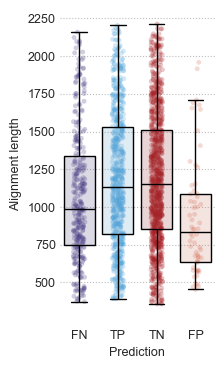

In [276]:
fig, ax = plt.subplots(figsize=(2,4))

var = "clustal_lengths"

# Boxplot
box = sns.boxplot(
    data=df,
    x="prediction",
    y=var,
    hue="prediction",
    showfliers=False,
    palette=tp_fn_pal,
    ax=ax,
    zorder=2
)

# Stripplot
sns.stripplot(
    data=df,
    x="prediction",
    y=var,
    palette=tp_fn_pal,
    hue="prediction",
    alpha=0.25,
    # zorder=0,
    jitter=.15,
    size=3.5,
    ax=ax,
    zorder=1
)


box_patches = [patch for patch in ax.patches if isinstance(patch, patches.PathPatch)]
if len(box_patches) == 0:
    box_patches = ax.artists

num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches

for i, patch in enumerate(box_patches):
    col = patch.get_facecolor()
    
    # Modify the alpha (opacity) value of the color
    col_with_opacity = col[:3] + (0.2,)  # Set alpha to 0.5 for 50% opacity
    
    patch.set_edgecolor("black")
    patch.set_facecolor(col_with_opacity)  # Set facecolor with opacity

    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color("black")
        line.set_mfc(col)  # facecolor of fliers
        line.set_mec("black")  # edgecolor of fliers


ax.set_xlabel("Prediction")
ax.set_ylabel("Alignment length")

style_vboxplot(ax)

plt.savefig("figures/baseline/alignment_length_by_classification_category.pdf",
            format="pdf",
            bbox_inches="tight",
            facecolor="white")

### Plot proportion of site class 3 for each prediction class

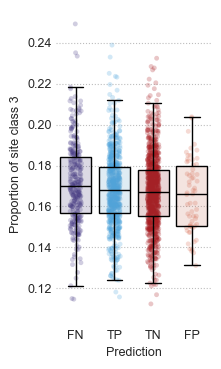

In [278]:
fig, ax = plt.subplots(figsize=(2,4))

var = "3_n_sites_normalised"

sns.boxplot(
    data=df,
    x="prediction",
    y=var,
    hue="prediction",
    showfliers=False,
    palette=tp_fn_pal,
    ax=ax,
    zorder=2
)


sns.stripplot(
    data=df,
    x="prediction",
    y=var,
    palette=tp_fn_pal,
    hue="prediction",
    alpha=.25,
    # zorder=0,
    jitter=.15,
    size=3.5,
    zorder=1
)

box_patches = [patch for patch in ax.patches if isinstance(patch, patches.PathPatch)]
if len(box_patches) == 0:
    box_patches = ax.artists

num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches

for i, patch in enumerate(box_patches):
    col = patch.get_facecolor()
    
    # Modify the alpha (opacity) value of the color
    col_with_opacity = col[:3] + (0.2,)  # Set alpha to 0.5 for 50% opacity
    
    patch.set_edgecolor("black")
    patch.set_facecolor(col_with_opacity)  # Set facecolor with opacity

    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color("black")
        line.set_mfc(col)  # facecolor of fliers
        line.set_mec("black")  # edgecolor of fliers

        
ax.set_xlabel("Prediction")
ax.set_ylabel("Proportion of site class 3")

style_vboxplot(ax)

plt.savefig("figures/baseline/proportion_of_siteclass3_by_classification_category.pdf",
            format="pdf",
            bbox_inches="tight",
            facecolor="white")

### Plot average codon saliency per prediction class per site class

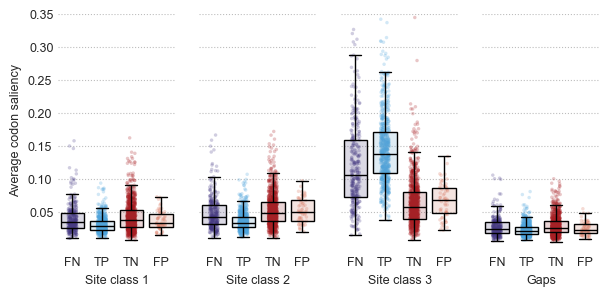

In [281]:
fig, axes = plt.subplots(1,4, figsize=(7,3),
                        sharey=True)

sns.set(font_scale=1.25)


for i in range(4):
    a = sns.boxplot(
            data=df,
            y="{}".format(i),
            x="prediction",
            hue="prediction",
            ax=axes[i],
            showfliers = False,
            palette=tp_fn_pal,
            zorder=2
        )
    
    a = sns.stripplot(
        data=df,
        y="{}".format(i),
        x="prediction",
        hue="prediction",
        ax=axes[i],
        alpha=.25,
        jitter=.15,
        palette=tp_fn_pal,
        size=2.5,
        zorder=1
    )

    axes[i].set_xlabel("Site class {}".format(i+1))
    axes[i].set_ylabel("")

    style_vboxplot(axes[i])

    box_patches = [patch for patch in axes[i].patches if isinstance(patch, patches.PathPatch)]
    if len(box_patches) == 0:
        box_patches = axes[i].artists
    
    num_patches = len(box_patches)
    lines_per_boxplot = len(axes[i].lines) // num_patches
    
    for j, patch in enumerate(box_patches):
        col = patch.get_facecolor()
        
        # Modify the alpha (opacity) value of the color
        col_with_opacity = col[:3] + (0.2,)  # Set alpha to 0.5 for 50% opacity
        
        patch.set_edgecolor("black")
        patch.set_facecolor(col_with_opacity)  # Set facecolor with opacity
    
        for line in axes[i].lines[j * lines_per_boxplot: (j + 1) * lines_per_boxplot]:
            line.set_color("black")
            line.set_mfc(col)  # facecolor of fliers
            line.set_mec("black")  # edgecolor of fliers
    axes[i].set_ylim(top=0.35)


axes[0].set_ylabel("Average codon saliency")
# sns.set_style("whitegrid")
axes[3].set_xlabel("Gaps")



plt.savefig("figures/baseline/codon_saliency_boxplots.pdf",
            format="pdf",
            bbox_inches="tight",
            facecolor="white")

### Plot average codon saliency per prediction class per site class, normalised by alignment length

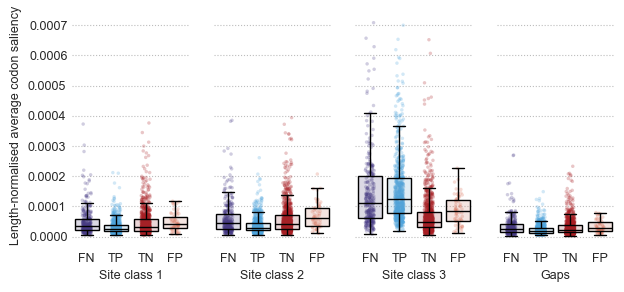

In [283]:
fig, axes = plt.subplots(1,4, figsize=(7,3),
                        sharey=True)

sns.set(font_scale=1.25)


for i in range(4):
    a = sns.boxplot(
        data=df,
        y="{}_length_normalised".format(i),
        x="prediction",
        hue="prediction",
        ax=axes[i],
        showfliers = False,
        palette=tp_fn_pal,
        zorder=2
    )
    a = sns.stripplot(
        data=df,
        y="{}_length_normalised".format(i),
        x="prediction",
        hue="prediction",
        ax=axes[i],
        alpha=.25,
        jitter=.15,
        palette=tp_fn_pal,
        size=2.5,
        zorder=1
    )

    for art_i, artist in enumerate(axes[i].artists):
        col1 = artist.get_facecolor()
        col = "black"

        r, g, b, a = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor((r, g, b, 0))
        for j in range(art_i*5,art_i*5+5):
            line = axes[i].lines[j]
            line.set_color(col)
            #line.set_mfc(col1)
            #line.set_mec(col1)
    axes[i].set_xlabel("Site class {}".format(i+1))
    axes[i].set_ylabel("")
    
    axes[i].set_ylim(top=0.00075)

    style_vboxplot(axes[i])

    box_patches = [patch for patch in axes[i].patches if isinstance(patch, patches.PathPatch)]
    if len(box_patches) == 0:
        box_patches = axes[i].artists
    
    num_patches = len(box_patches)
    lines_per_boxplot = len(axes[i].lines) // num_patches
    
    for j, patch in enumerate(box_patches):
        col = patch.get_facecolor()
        
        # Modify the alpha (opacity) value of the color
        col_with_opacity = col[:3] + (0.2,)  # Set alpha to 0.5 for 50% opacity
        
        patch.set_edgecolor("black")
        patch.set_facecolor(col_with_opacity)  # Set facecolor with opacity
    
        for line in axes[i].lines[j * lines_per_boxplot: (j + 1) * lines_per_boxplot]:
            line.set_color("black")
            line.set_mfc(col)  # facecolor of fliers
            line.set_mec("black")  # edgecolor of fliers

    
axes[0].set_ylabel("Length-normalised average codon saliency")
sns.set_style("whitegrid")
axes[3].set_xlabel("Gaps")


plt.savefig("figures/baseline/length_normalised_codon_saliency_boxplots.pdf",
            format="pdf",
            bbox_inches="tight",
            facecolor="white")

### Plot ω2 for true positive and false negative alignments

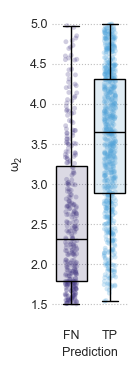

In [287]:
tp_fn_df = df[df["prediction"].isin(["TP", "FN"])]

fig, ax = plt.subplots(figsize=(1,4))

sns.boxplot(
    data=tp_fn_df,
    x="prediction",
    hue="prediction",
    y="omega_2",
    palette=tp_fn_pal,
    zorder=2
)

sns.stripplot(
    data=tp_fn_df,
    x="prediction",
    y="omega_2",
    palette=tp_fn_pal,
    hue="prediction",
    alpha=.25,
    jitter=.15,
    size=3.5,
    zorder=1
)

ax.set_xlabel("Prediction")
ax.set_ylabel("$ω_2$")

style_vboxplot(ax)


box_patches = [patch for patch in ax.patches if isinstance(patch, patches.PathPatch)]
if len(box_patches) == 0:
    box_patches = ax.artists

num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches

for i, patch in enumerate(box_patches):
    col = patch.get_facecolor()
    
    # Modify the alpha (opacity) value of the color
    col_with_opacity = col[:3] + (0.2,)  # Set alpha to 0.5 for 50% opacity
    
    patch.set_edgecolor("black")
    patch.set_facecolor(col_with_opacity)  # Set facecolor with opacity

    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color("black")
        line.set_mfc(col)  # facecolor of fliers
        line.set_mec("black")  # edgecolor of fliers


plt.savefig("figures/baseline/omega2_for_tp_vs_fn.pdf",
            format="pdf",
            bbox_inches="tight",
            facecolor="white")

### Plot ω2 vs. saliency

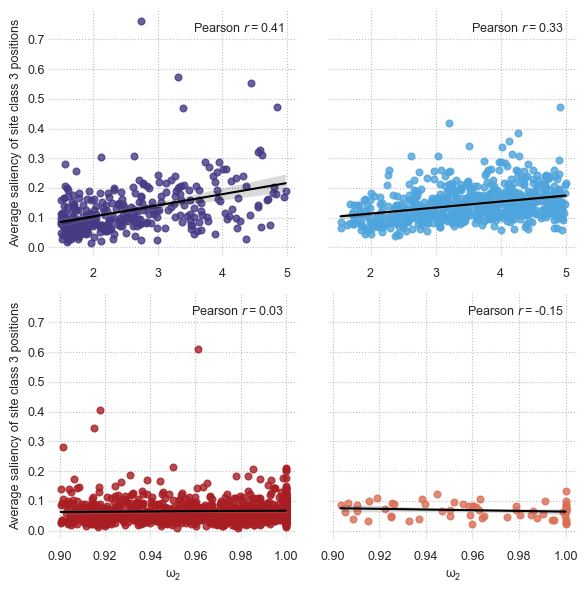

In [158]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6), sharey=True)

ax_flat = ax.flatten()

for ax_i, pred_class in enumerate(["FN", "TP", "TN", "FP"]):
    pred_class_df = df[df["prediction"] == pred_class]
    pred_class_df = pred_class_df.dropna()
    corr = stats.pearsonr(pred_class_df["omega_2"], pred_class_df["2"])
    sns.regplot(
        data=pred_class_df,
        x="omega_2",
        y="2",
        color=tp_fn_pal[pred_class],
        line_kws={"color": "black", "linewidth": 1.5},  # Set trend line color and linewidth
        ax=ax_flat[ax_i]
    )
    ax_flat[ax_i].set_xlabel("")
    ax_flat[ax_i].set_ylabel("")
    ax_flat[ax_i].text(
        0.95, 0.95, r"Pearson $\mathit{r}" + " = ${:.2f}".format(corr[0]),
        transform=ax_flat[ax_i].transAxes, ha='right', va='top',
    )
    style_scatterplot(ax_flat[ax_i])

for ax_i in [0, 2]:
    ax_flat[ax_i].set_ylabel("Average saliency of site class 3 positions")

# Add x-axis label to the bottom row
for i in range(2, 4):
    ax_flat[i].set_xlabel("$ω_{2}$")

fig.tight_layout()


plt.savefig("figures/baseline/site_class_3_saliency_vs_w2_values.pdf",
            format="pdf",
            bbox_inches="tight",
            facecolor="white")

### Plot ω2 distributions for each class of simulation

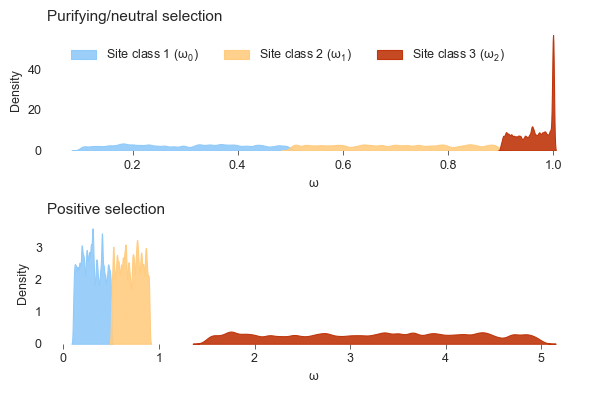

In [155]:
fig, axes = plt.subplots(2,1,figsize=(6,4))

site_pal = ["#90CAF9", "#FFCC80", "#BF360C"]


for true_y in range(2):
    true_data = df[df["true_y"] == true_y]
    for omega in range(3):
        sns.kdeplot(
            data=true_data,
            x="omega_{}".format(omega),
            ax=axes[true_y],
            label="Site class {0} ($ω_{1}$)".format(omega+1, omega),
            fill=True,
            color=site_pal[omega],
            alpha=.9,
            bw_adjust=0.2
        )

axes[0].set_title("Purifying/neutral selection", loc="left")
axes[1].set_title("Positive selection", loc="left")
axes[0].set_xlabel("ω")
axes[1].set_xlabel("ω")

for ax_i in [0,1]:
    style_kdeplot(axes[ax_i])
    # axes[ax_i].set_xlim(0,5.5)

axes[0].legend(frameon=False, bbox_to_anchor=(.88, .95), ncol=3)

# sns.set(palette=site_pal,
#         style="whitegrid",
#         font_scale=1.75)
sns.despine(left=True, bottom=True)
 
axes[0].grid(False)
axes[1].grid(False)
    
# fig.subplots_adjust(hspace=.3)

fig.tight_layout()


plt.savefig("figures/baseline/site_omega_kdes.pdf",
            format="pdf",
            bbox_inches="tight",
            facecolor="white")

### Plot proportion of site class within each saliency bin for each prediction category

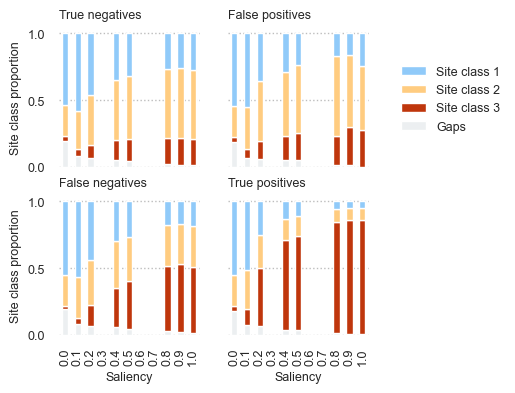

In [268]:
cmap = [
    "#90CAF9",
    "#FFCC80",
    "#BF360C",
    "#ECEFF1"][::-1]

pred_dic = {
    "TN": "True negatives",
    "FP": "False positives",
    "FN": "False negatives",
    "TP": "True positives"
}

fig, axes = plt.subplots(2, 2,
                         figsize=(4,4),
                         sharex=True,
                         sharey=True)

ax_c = 0
ax_c2 = -1

style = style_constants()

for pred in ["TN", "FP", "FN", "TP"]:
    ax_c2 += 1
    if ax_c2 == 2:
        ax_c2 = 0
        ax_c += 1
    sal_class_counts = []
    for i in range(0,11):
        sal_key = i/10
        sal_class_count = []
        for site_class in [3,2,1,0]:
            sal_class_count.append(saliency_bins[pred][sal_key].count(site_class))
        with warnings.catch_warnings():
            warnings.filterwarnings("error")  # Raise warnings as errors
            try:
                sal_class_count = [i / np.asarray(sal_class_count).sum() for i in sal_class_count]
            except RuntimeWarning:
                sal_class_count = [np.nan, np.nan, np.nan, np.nan]
        sal_class_count.insert(0, sal_key)
        sal_class_counts.append(sal_class_count)

    sal_df = pd.DataFrame(sal_class_counts,
                          columns=["saliency"] + ["Site class 1", "Site class 2", "Site class 3", "Gaps"][::-1])

    barc = sal_df.set_index("saliency").plot(
        kind='bar',
        stacked=True,
        ax=axes[ax_c][ax_c2],
        color=cmap,
        edgecolor="white",
        legend=False,
        fontsize=9
    )

    axes[ax_c][ax_c2].set_xlabel("Saliency", fontsize=9)
    axes[ax_c][ax_c2].set_ylabel("Site class proportion", fontsize=9)
    axes[ax_c][ax_c2].xaxis.grid(False)
    axes[ax_c][ax_c2].yaxis.grid(color=style["grey"], linestyle=":")
    axes[ax_c][ax_c2].set_title(pred_dic[pred], loc="left", fontsize=9)
    axes[ax_c][ax_c2].spines['top'].set_visible(False)
    axes[ax_c][ax_c2].spines['right'].set_visible(False)
    axes[ax_c][ax_c2].spines['bottom'].set_visible(False)
    axes[ax_c][ax_c2].spines['left'].set_visible(False)


handles, labels = axes[ax_c][ax_c2].get_legend_handles_labels()
legend = axes[ax_c][ax_c2].legend(reversed(handles), reversed(labels),
                                  loc='upper left', bbox_to_anchor=(1.15, 2), fontsize=9, frameon=False)
for text in legend.get_texts():
    text.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='none'))

sns.set_style("white")
style_fonts()

plt.savefig("figures/baseline/saliency_proportion_of_site_classes.pdf",
            bbox_inches="tight",
            format="pdf",
            facecolor="white")

### Plot clustal alignment vs. M8-M7 BEB ω2 estimates vs. the ωCNN saliency map

In [194]:
tp_df_long = tp_df[tp_df["clustal_lengths"] > 1500]
tp_bayes_df_long = tp_bayes_df[tp_df["clustal_lengths"] > 1500]

assert tp_df_long.index.equals(tp_bayes_df_long.index)

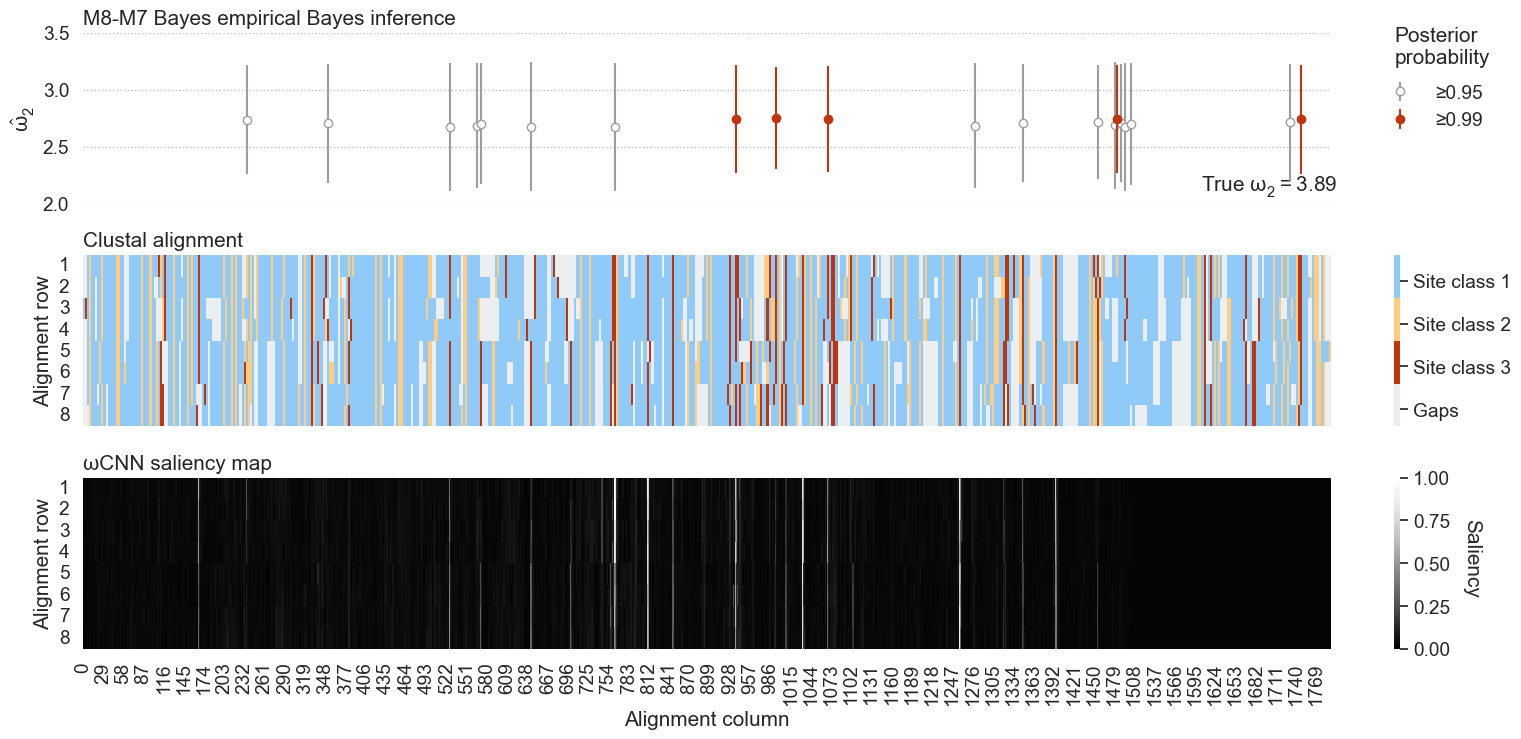

In [236]:
cm = inspect_true_maps(tp_df_long, tp_bayes_df_long, 7)

plt.savefig(
    "figures/baseline/example_alignment_vs_M8M7_bayes_vs_wnn_saliency_map.pdf",
    format="pdf",
    bbox_inches="tight",
    facecolor="white"
)